# Import and Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q lda
!pip install -q "tmtoolkit[recommended, lda]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.8/349.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import warnings
import pandas as pd
import numpy as np
import random
import operator
import itertools
import gzip
import json
import pickle

from lda import LDA
import scipy.sparse
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, filter_clean_tokens
from tmtoolkit.corpus import remove_common_tokens, remove_uncommon_tokens, print_summary, dtm
from tmtoolkit.corpus.visualize import plot_doc_lengths_hist, plot_ranked_vocab_counts
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 2004
random.seed(SEED)
np.set_printoptions(precision=5)
warnings.filterwarnings("ignore")

DIR = 'drive/MyDrive/dtsa5799_product_review_topic_model'
DATA_DIR = '%s/data' % DIR

# Process Corpus

In [ ]:
# load list best_asins from bestnikeasins.txt
best_asins_path = f'{DATA_DIR}/bestnikeasins.txt'
with open(best_asins_path, 'r') as f:
    best_asins = f.read().split(',')

In [ ]:
# load dict top_texts from top_reviewstext.jsonl
top_texts = {}
top_texts_path = f'{DATA_DIR}/top_reviewstext.jsonl'
with open(top_texts_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        top_texts.update(data)

In [ ]:
for i, (id, text) in enumerate(list(top_texts.items())[:5]):
    print(i, id, text[:80])

0 B0000V9K32.ACT5DY536GISV the colour i received is not blue as shown but yellow.Couldnt change it because 
1 B0000V9K32.A3BVWMS9I8OH8U Very cute and is really practical. Fits better on smaller wrists which is my cas
2 B0000V9KRI.AR7L2ZP173QEE good price, very good material and excellent design, very useful for traveling, 
3 B0000V9KRI.A1BEBWGPSB2DLM I mean, Roxy rocks, but I'm kinda dissapointed with the material. The purse lokk
4 B0000V9KRI.A1EDPEDXSQ78G4 I love this watch, i use every day, every where, to work, to go to the gym, pool


In [ ]:
def build_corpus(text_dict, corpus_size=None, lang='en'):
    corpus = Corpus(text_dict, language=lang)
    #to_lowercase(corpus)
    lemmatize(corpus)
    filter_clean_tokens(corpus,
                        remove_punct=True,
                        remove_stopwords=True,
                        remove_empty=True,
                        remove_numbers=True,
                        remove_shorter_than=3,
                        remove_longer_than=20
                        )
    if corpus_size =='small':
        remove_common_tokens(corpus, df_threshold=0.88)
        remove_uncommon_tokens(corpus, df_threshold=0.003)
    if corpus_size == 'big':
        remove_common_tokens(corpus, df_threshold=0.98)
        remove_uncommon_tokens(corpus, df_threshold=0.0003)

    print_summary(corpus)
    return corpus

In [ ]:
lo_top_texts = {key: value.lower() for key, value in top_texts.items()}

In [ ]:
for i, (id, text) in enumerate(list(lo_top_texts.items())[:5]):
    print(i, id, text[:80])

0 B0000V9K32.ACT5DY536GISV the colour i received is not blue as shown but yellow.couldnt change it because 
1 B0000V9K32.A3BVWMS9I8OH8U very cute and is really practical. fits better on smaller wrists which is my cas
2 B0000V9KRI.AR7L2ZP173QEE good price, very good material and excellent design, very useful for traveling, 
3 B0000V9KRI.A1BEBWGPSB2DLM i mean, roxy rocks, but i'm kinda dissapointed with the material. the purse lokk
4 B0000V9KRI.A1EDPEDXSQ78G4 i love this watch, i use every day, every where, to work, to go to the gym, pool


### corpus

In [ ]:
corp = build_corpus(lo_top_texts)

Corpus with 13380 documents in English
> B00012O2O2.A8JNZ93ZMSX2F (18 tokens): watch ideal person small wrist look nice light gre...
> B00012O2O2.A18GGD59BKK1V9 (21 tokens): watch color love picture misleading multicolore ni...
> B00012O2O2.A2RT3G75H4UCFE (12 tokens): great little watch price wear work lot compliment ...
> B00012O2S8.A1RYOBXF3RBCNR (13 tokens): buy watch black colour love decide buy present fri...
> B0000V9KRI.AR7L2ZP173QEE (13 tokens): good price good material excellent design useful t...
> B0000V9KRI.A1EDPEDXSQ78G4 (12 tokens): love watch use day work gym pool sport etc evethe ...
> B0000V9K32.A3BVWMS9I8OH8U (10 tokens): cute practical fit well small wrist case wear love...
> B0000V9K32.ACT5DY536GISV (14 tokens): colour receive blue show yellow.couldnt change bir...
> B00012O2O2.ANG4H72G3LGI0 (35 tokens): great hope watch want funky cool change spring-- c...
> B0000V9KRI.A1BEBWGPSB2DLM (11 tokens): mean roxy rock kinda dissapointe material purse lo...
(and 13370 more

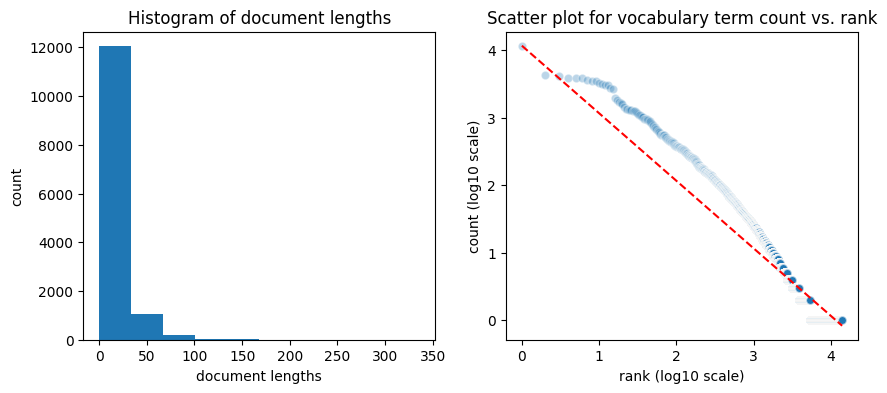

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_doc_lengths_hist(fig, axs[0], corp, y_log=False)
plot_ranked_vocab_counts(fig, axs[1], corp, zipf=True)
plt.show()

In [ ]:
# save corpus
corp_path = f'{DATA_DIR}/corpus.p'
pickle.dump(corp, open(corp_path, 'wb'))

### corpus small

In [ ]:
corp_sm = build_corpus(lo_top_texts, corpus_size='small')

Corpus with 13380 documents in English
> B00012O2O2.A8JNZ93ZMSX2F (16 tokens): watch person small wrist look nice light green loo...
> B00012O2O2.A18GGD59BKK1V9 (16 tokens): watch color love picture nice green watch arrive b...
> B00012O2O2.A2RT3G75H4UCFE (11 tokens): great little watch price wear work lot compliment ...
> B00012O2S8.A1RYOBXF3RBCNR (12 tokens): buy watch black colour love decide buy present fri...
> B0000V9KRI.AR7L2ZP173QEE (11 tokens): good price good material excellent design travel t...
> B0000V9KRI.A1EDPEDXSQ78G4 (10 tokens): love watch use day work gym sport etc time good
> B0000V9K32.A3BVWMS9I8OH8U (9 tokens): cute fit well small wrist case wear love watch
> B0000V9K32.ACT5DY536GISV (11 tokens): colour receive blue show change birthday present d...
> B00012O2O2.ANG4H72G3LGI0 (26 tokens): great hope watch want cool change color photo thin...
> B0000V9KRI.A1BEBWGPSB2DLM (6 tokens): mean rock kinda material bit cheap
(and 13370 more documents)
total number of tokens

In [ ]:
# save corpus
corp_sm_path = f'{DATA_DIR}/corp_sm.p'
pickle.dump(corp_sm, open(corp_sm_path, 'wb'))

### corpus big

In [ ]:
corp_bg = build_corpus(lo_top_texts, corpus_size='big')

Corpus with 13380 documents in English
> B00012O2O2.A8JNZ93ZMSX2F (18 tokens): watch ideal person small wrist look nice light gre...
> B00012O2O2.A18GGD59BKK1V9 (17 tokens): watch color love picture nice green watch arrive d...
> B00012O2O2.A2RT3G75H4UCFE (12 tokens): great little watch price wear work lot compliment ...
> B00012O2S8.A1RYOBXF3RBCNR (13 tokens): buy watch black colour love decide buy present fri...
> B0000V9KRI.AR7L2ZP173QEE (12 tokens): good price good material excellent design useful t...
> B0000V9KRI.A1EDPEDXSQ78G4 (11 tokens): love watch use day work gym pool sport etc time go...
> B0000V9K32.A3BVWMS9I8OH8U (10 tokens): cute practical fit well small wrist case wear love...
> B0000V9K32.ACT5DY536GISV (11 tokens): colour receive blue show change birthday present d...
> B00012O2O2.ANG4H72G3LGI0 (30 tokens): great hope watch want funky cool change color cont...
> B0000V9KRI.A1BEBWGPSB2DLM (9 tokens): mean rock kinda dissapointe material purse lil bit...
(and 13370 more 

In [ ]:
# save corpus
corp_bg_path = f'{DATA_DIR}/corp_bg.p'
pickle.dump(corp_bg, open(corp_bg_path, 'wb'))

In [ ]:
# get dtm, doc_labels, vocab
dtm_sm, doc_labels_sm, vocab_sm = dtm(corp_sm, return_doc_labels=True, return_vocab=True)
dtm_bg, doc_labels_bg, vocab_bg = dtm(corp_bg, return_doc_labels=True, return_vocab=True)

In [ ]:
# save
scipy.sparse.save_npz(f'{DATA_DIR}/dtm_sm.npz', dtm_sm)
scipy.sparse.save_npz(f'{DATA_DIR}/dtm_bg.npz', dtm_bg)

pickle.dump(doc_labels_sm, open(f'{DATA_DIR}/doc_labels_sm.p', 'wb'))
pickle.dump(doc_labels_bg, open(f'{DATA_DIR}/doc_labels_bg.p', 'wb'))

pickle.dump(vocab_sm, open(f'{DATA_DIR}/vocab_sm.p', 'wb'))
pickle.dump(vocab_bg, open(f'{DATA_DIR}/vocab_bg.p', 'wb'))

### zero row

check if there are any dtm zero rows after corpus processing

In [ ]:
# load
dtm_sm = scipy.sparse.load_npz(f'{DATA_DIR}/dtm_sm.npz')
dtm_bg = scipy.sparse.load_npz(f'{DATA_DIR}/dtm_bg.npz')

doc_labels_sm = pickle.load(open(f'{DATA_DIR}/doc_labels_sm.p', 'rb'))
doc_labels_bg = pickle.load(open(f'{DATA_DIR}/doc_labels_bg.p', 'rb'))

vocab_sm = pickle.load(open(f'{DATA_DIR}/vocab_sm.p', 'rb'))
vocab_bg = pickle.load(open(f'{DATA_DIR}/vocab_bg.p', 'rb'))

In [ ]:
dtm_sm.shape[0], dtm_bg.shape[0]

(13380, 13380)

In [ ]:
def check_zero_row(dtm, doc_ids, texts_dict):
    zero_row_indices = np.where(dtm.getnnz(axis=1) == 0)[0]
    zero_doc_ids = [doc_ids[i] for i in zero_row_indices]
    zero_texts = {doc_id: texts_dict[doc_id] for doc_id in zero_doc_ids}
    if zero_texts:
        for doc_id, text in zero_texts.items():
            print(f"Document ID: {doc_id}, Text: {text}")
        print(f'{len(zero_texts)} zero rows found')
    else:
        print('No zero row')

In [ ]:
def update_dtm_and_docs(dtm, doc_ids, top_texts, name):
    zero_row_indices = np.where(dtm.getnnz(axis=1) == 0)[0]

    if zero_row_indices.size > 0:
        deleted_doc_ids = [doc_ids[i] for i in zero_row_indices]
        print("Deleted doc ids:", deleted_doc_ids)
        dtm = dtm[~np.isin(np.arange(dtm.shape[0]), zero_row_indices), :]
        new_doc_ids = [doc_ids[i] for i in range(len(doc_ids)) if i not in zero_row_indices]
        new_top_texts = {doc_id: top_texts[doc_id] for doc_id in new_doc_ids if doc_id in top_texts}
        print(f"{len(deleted_doc_ids)} rows have been deleted")

        with open(f'{DATA_DIR}/deleted_doc_ids_{name}.txt', 'w') as f:
            for doc_id in deleted_doc_ids:
                f.write(f"{doc_id}\n")
        with open(f'{DATA_DIR}/top_texts_{name}.json', 'w') as f:
            json.dump(new_top_texts, f, ensure_ascii=False, indent=4)
        print('files saved')
    else:
        print("No rows have been deleted")

    return dtm, new_doc_ids, new_top_texts

In [ ]:
doc_ids = list(top_texts.keys())

#### corpus small

In [ ]:
check_zero_row(dtm_sm, doc_ids, top_texts)

Document ID: B000E8J50Y.A2FVT7AYPJ27CW, Text: This watch is a perfect durable, every day watch that has held up to water, construction work, and constant, every day wear and tear.  And it was just "retro" enough to gain compliments for the 1980's kickback.  If it had a calculator....watch out for the NERD ALERT!  GREAT PRODUCT!
Document ID: B000G42Z2Q.A2WP2PC1JH3YUX, Text: Shoe is good and seems to fit well.  Have used it some for parkouring.  Like the stylish look of the black and blue color.
Document ID: B000G42Z2Q.A1DUFYK7NU8URW, Text: So cutteFit as expectedso good for trainingit was the best one that i got right now :)
Document ID: B000J2F8GK.A2SSC07XFGTAV4, Text: This was a gift to my son and he was very happy with the shoes.  He wears them to play basketball and is in love with the shoes.
Document ID: B001V6PNRW.AJM05EYT7T0KM, Text: Always buy Nike brand, this was a great price and came on time. Nike is always a good brand, can't beat it.
Document ID: B0024FQIRI.A1AHXHNHK3CMXF, 

In [ ]:
dtm_sm, doc_ids_sm, top_texts_sm = update_dtm_and_docs(dtm_sm, doc_ids, top_texts, 'sm')

Deleted doc ids: ['B000E8J50Y.A2FVT7AYPJ27CW', 'B000G42Z2Q.A2WP2PC1JH3YUX', 'B000G42Z2Q.A1DUFYK7NU8URW', 'B000J2F8GK.A2SSC07XFGTAV4', 'B001V6PNRW.AJM05EYT7T0KM', 'B0024FQIRI.A1AHXHNHK3CMXF', 'B0024FQIRI.A1NTR4NXLZEBKX', 'B002FKHOOS.A1XMRKHPOQD72Y', 'B004LBKEPU.A2KH2RCKX8ABZG', 'B005525IGO.A3JH357ASXJM8N', 'B0058YCZ1K.A1R72RTTH20TA9', 'B0058YDA6E.A1Q20SCKBRWNZ', 'B0059D7FVK.ACFW6TMOYGJYN', 'B0059P28MY.A1ZDEMJI2FOC61', 'B005BQXZXC.A10LYRPZ4QHKP1', 'B005OB5384.A1ILKZQZS0RIUR', 'B005OB65TK.A1JD6APD3GUO13', 'B006OBWFE8.A33U0ABT17FRZT', 'B006OBWTSA.AONX6QGGUA3KI', 'B006OBWTSA.A2YTYOL5145GCH', 'B006RBH2PW.A2G98R8S0EULV6', 'B006RBH2PW.A1KOR9BO9UPCYG', 'B006X79XWA.A10ZM9G2PNKUB7', 'B007LO1RPU.AODC1LKKPNMY0', 'B007X93BZM.AXV1UNUJAVK26', 'B0098G7Q1S.A15XZFMT2VL1DB', 'B009R8HDII.A2BXMQUNPD111R', 'B00AMTXXWG.A1EYA60DRSNIDO', 'B00AMU06N4.ALH67I89RZCB', 'B00AMU06N4.A1QRWSDG9TKO4H', 'B00AMU1YB2.A241J7ZR8CLOYM', 'B00AQ9I084.AS7HE6KNU3FTZ', 'B00BJ803IQ.A3IFJNT2ZFFUCA', 'B00BLT5GMG.A2IPRTA4JHNDDZ', 'B00B

In [ ]:
check_zero_row(dtm_sm, doc_ids_sm, top_texts_sm)

No zero row


#### corpus big

In [ ]:
check_zero_row(dtm_bg, doc_ids, top_texts)

Document ID: B000G42Z2Q.A2WP2PC1JH3YUX, Text: Shoe is good and seems to fit well.  Have used it some for parkouring.  Like the stylish look of the black and blue color.
Document ID: B000J2F8GK.A2SSC07XFGTAV4, Text: This was a gift to my son and he was very happy with the shoes.  He wears them to play basketball and is in love with the shoes.
Document ID: B001V6PNRW.AJM05EYT7T0KM, Text: Always buy Nike brand, this was a great price and came on time. Nike is always a good brand, can't beat it.
Document ID: B0024FQIRI.A1AHXHNHK3CMXF, Text: Bought these for my husband for Christmas and he loves them. He's a shoe addict and has almost a hundred pair of sneakers and he said that these are very comfortable and stylish. He did mention though that they were a tad big tight (near the instep area) but loosened up as he wore them and now they fit perfectly.
Document ID: B002FKHOOS.A1XMRKHPOQD72Y, Text: love this pair, they are light and very confe... stylish too, I get lots of compliments.I usuall

In [ ]:
dtm_bg, doc_ids_bg, top_texts_bg = update_dtm_and_docs(dtm_bg, doc_ids, top_texts, 'bg')

Deleted doc ids: ['B000G42Z2Q.A2WP2PC1JH3YUX', 'B000J2F8GK.A2SSC07XFGTAV4', 'B001V6PNRW.AJM05EYT7T0KM', 'B0024FQIRI.A1AHXHNHK3CMXF', 'B002FKHOOS.A1XMRKHPOQD72Y', 'B0059D7FVK.ACFW6TMOYGJYN', 'B005BQXZXC.A10LYRPZ4QHKP1', 'B005OB5384.A1ILKZQZS0RIUR', 'B006X79XWA.A10ZM9G2PNKUB7', 'B00AMTXXWG.A1EYA60DRSNIDO', 'B00AMU06N4.A1QRWSDG9TKO4H', 'B00AMU1YB2.A241J7ZR8CLOYM', 'B00AQ9I084.AS7HE6KNU3FTZ', 'B00BLT5GMG.A2IPRTA4JHNDDZ', 'B00BNFQ8M0.A3H481RDA9I4DV', 'B00C1SOINY.A2VMISC01K95F9', 'B00E8RZ5UQ.AIN2ETEAP7B1M', 'B00EIX9V50.A00151103W37UJ3ZZ2WDZ', 'B00EQJ5HA4.A2BAW2MKOPVHSO', 'B00GCDE2KS.A2GR9VUD3K6UJ7', 'B00GY0IBY2.A3TU3298FVEDE3', 'B00HFTJEH4.A2FITEUJNJ4WH2', 'B00IT6ATEY.A12B13L9NOFMA6']
23 rows have been deleted
files saved


In [ ]:
check_zero_row(dtm_bg, doc_ids_bg, top_texts_bg)

No zero row


In [ ]:
# save
scipy.sparse.save_npz(f'{DATA_DIR}/new_dtm_sm.npz', dtm_sm)
scipy.sparse.save_npz(f'{DATA_DIR}/new_dtm_bg.npz', dtm_bg)

pickle.dump(doc_labels_sm, open(f'{DATA_DIR}/new_doc_labels_sm.p', 'wb'))
pickle.dump(doc_labels_bg, open(f'{DATA_DIR}/new_doc_labels_bg.p', 'wb'))

pickle.dump(vocab_sm, open(f'{DATA_DIR}/new_vocab_sm.p', 'wb'))
pickle.dump(vocab_bg, open(f'{DATA_DIR}/new_vocab_bg.p', 'wb'))